In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import json
import pickle
import os
import sys
import torch
from omegaconf import OmegaConf
from monai.metrics import DiceMetric
from sklearn import metrics
from torch.utils.data import DataLoader

In [2]:
REPO_PATH = "/workspace/repositories/DSSQ/src"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
sys.path.append(REPO_PATH)

from models import get_unet
from data_utils import get_eval_data
from adapters import DimReductAdapter, DimReductModuleWrapper

### Load basic config
# DATA_KEY = "heart"
DATA_KEY = "prostate"
LOG = False
LOAD_ONLY_PRESENT = True
VALIDATION = True  # If false makes validation set be the training one
EXTRA_DESCRIPTION = "_base"
MODE = "eval"
N_DIMS = [32, 960]
models = ["monai-64-4-4", "swinunetr"]
train_vendors = ["siemens"]
test_vendors = ["siemens", "philips", "ge"]
dim_red_modes = ["IPCA", "PCA", "AVG_POOL"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_conf(unet_name="", iteration=0, data_key="prostate"):
    cfg = OmegaConf.load(f"{REPO_PATH}/configs/conf.yaml")
    OmegaConf.update(cfg, "run.iteration", iteration)
    OmegaConf.update(cfg, "run.data_key", data_key)
    args = unet_name.split("-")
    cfg.wandb.log = LOG
    cfg.unet[data_key].pre = unet_name
    cfg.unet[data_key].arch = args[0]
    cfg.unet[data_key].n_filters_init = int(args[1]) if "monai" in unet_name else None
    cfg.unet[data_key].training.load_only_present = LOAD_ONLY_PRESENT
    cfg.unet[data_key].training.validation = VALIDATION
    cfg.unet[data_key].training.batch_size = 32
    cfg.wandb.project = f"{data_key}_{unet_name}_{iteration}{EXTRA_DESCRIPTION}"
    if MODE == "eval":
        cfg.format = "numpy"
    layer_names = None
    if "monai" in unet_name:
        cfg.unet[data_key].depth = int(args[2])
        cfg.unet[data_key].num_res_units = int(args[3])
        layer_names = [
            f'model.{"1.submodule." * i}0.conv' for i in range(cfg.unet[DATA_KEY].depth)
        ]
        layer_names.append("model.1.submodule.1.submodule.2.0.conv")
    elif unet_name == "swinunetr":
        layer_names = ["encoder2", "encoder3", "encoder4", "encoder10"]
    return cfg, layer_names

@torch.no_grad()
def eval_data(cfg, model, dataset):
    if hasattr(model, "empty_data"):
        model.empty_data()
    model.eval()
    dice_scores = []
    seg_masks = []
    dm = DiceMetric(ignore_empty=True, include_background=False)
    dataloader = DataLoader(
        dataset,
        batch_size=cfg.unet.prostate.training.batch_size,
        shuffle=False,
        drop_last=False,
    )
    for batch in dataloader:
        input_ = batch["input"].cuda()
        target = batch["target"]
        out = model(input_)
        seg_mask = torch.argmax(out, dim=1).unsqueeze(1)
        batch_dices = dm(seg_mask.detach().cpu(), target)
        seg_masks.append(seg_mask)
        dice_scores.append(batch_dices)

    dice_scores = torch.cat(dice_scores, dim=0).squeeze().detach().cpu().numpy()
    seg_masks = torch.cat(seg_masks, dim=0).detach().cpu()
    return dice_scores, seg_masks

monai_iter = 1
swin_iter = 0

In [3]:
all_eval_data = {}
dices_vendor = {}
for ven in test_vendors:
    dices_vendor[ven] = {}
    cfg, _ = load_conf(data_key=DATA_KEY)
    cfg.unet[DATA_KEY].training.subset = (
        "validation" if ven in train_vendors else False
    )
    cfg.unet[DATA_KEY].training.vendor = ven
    data = get_eval_data(eval_set=True, cfg=cfg)
    all_eval_data[ven] = data['eval']
    for model in models:
        dices_vendor[ven][model] = {}
        if "monai" in model:
            iteration = monai_iter
        else:
            iteration = swin_iter
        cfg, layer_names = load_conf(model, iteration=iteration, data_key=DATA_KEY)
        model_base, state_dict = get_unet(cfg, return_state_dict=True)
        model_base = model_base.to(device)
        model_base.eval()
        model_base_dices, model_base_segs = eval_data(cfg, model_base, data["eval"])
        dices_vendor[ven][model]['DS'] = model_base_dices
        dices_vendor[ven][model]['seg'] = model_base_segs

Loading evaluation PMRI dataset for vendor siemens ...


Loaded model from epoch 66 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_1_base_1_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 38 and path:
/workspace/out/weights/prostate_swinunetr_prostate_swinunetr_0_base_0_best.pt
Loading evaluation PMRI dataset for vendor philips ...
Loaded model from epoch 66 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_1_base_1_best.pt
Loaded model from epoch 38 and path:
/workspace/out/weights/prostate_swinunetr_prostate_swinunetr_0_base_0_best.pt
Loading evaluation PMRI dataset for vendor ge ...
Loaded model from epoch 66 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_1_base_1_best.pt
Loaded model from epoch 38 and path:
/workspace/out/weights/prostate_swinunetr_prostate_swinunetr_0_base_0_best.pt


In [21]:
def plot_idx(idx_siem, idx_phil, idx_ge):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    i = 0
    for ven in test_vendors:
        if 'phil' in ven: arbitrary_idx = idx_phil
        elif 'siem' in ven: arbitrary_idx = idx_siem
        elif 'ge' in ven: arbitrary_idx = idx_ge
        print(ven, arbitrary_idx)
        if i == 0:
            axes[i][0].set_title('Image', fontsize=10)
            axes[i][1].set_title('Target', fontsize=10)
            axes[i][2].set_title('Predicted', fontsize=10)
            axes[i][3].set_title('Difference', fontsize=10)
            axes[i][4].set_title('Overlay', fontsize=10)
        axes[i, 0].imshow(all_eval_data[ven][arbitrary_idx]['input'][0, ...], cmap='gray')
        axes[i, 1].imshow(all_eval_data[ven][arbitrary_idx]['target'][0, ...], cmap='gray')
        img = dices_vendor[ven]['monai-64-4-4']['seg'][arbitrary_idx]
        print(ven, dices_vendor[ven]['monai-64-4-4']['DS'][arbitrary_idx])
        axes[i, 2].imshow(img[0, ...], cmap='gray')
        diff = torch.abs(img[0, ...] - all_eval_data[ven][arbitrary_idx]['target'][0, ...])
        axes[i, 3].imshow(diff, cmap='gray')
        axes[i, 4].imshow(all_eval_data[ven][arbitrary_idx]['target'][0, ...], cmap='Blues', alpha=1)
        axes[i, 4].imshow(img[0, ...], cmap='Reds', alpha=0.5)
        axes[i, 4].imshow(all_eval_data[ven][arbitrary_idx]['input'][0, ...], cmap='gray', alpha=0.7)
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 3].axis('off')
        axes[i, 4].axis('off')
        i += 1
    # red_patch = mpatches.Patch(color='red', label='Predicted', alpha=0.5)
    # green_patch = mpatches.Patch(color='green', label='Target', alpha=0.5)
    # plt.legend(handles=[red_patch, green_patch], loc='upper right')
    fig.text(0.1, 0.75, 'Siemens', ha='center', va='center', rotation='vertical', fontsize=10)
    fig.text(0.1, 0.45, 'Philips', ha='center', va='center', rotation='vertical', fontsize=10)
    fig.text(0.1, 0.17, 'GE', ha='center', va='center', rotation='vertical', fontsize=10)
    # plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout(rect=[0.1, 0, 1, 1])
    plt.savefig('/workspace/out/plots/seg_mask_example.png', dpi=1200, bbox_inches='tight')
    plt.show()
    

def plot_idx_2(idx_siem, idx_ge):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(2, 5, figsize=(5, 2))
    i = 0
    for ven in test_vendors:
        if 'siem' in ven: arbitrary_idx = idx_siem
        elif 'ge' in ven: arbitrary_idx = idx_ge
        else: continue
        print(ven, arbitrary_idx)
        if i == 0:
            axes[i][0].set_title('Image', fontsize=10)
            axes[i][1].set_title('Target', fontsize=10)
            axes[i][2].set_title('Predicted', fontsize=10)
            axes[i][3].set_title('Difference', fontsize=10)
            axes[i][4].set_title('Overlay', fontsize=10)
        axes[i, 0].imshow(all_eval_data[ven][arbitrary_idx]['input'][0, ...], cmap='gray')
        axes[i, 1].imshow(all_eval_data[ven][arbitrary_idx]['target'][0, ...], cmap='gray')
        img = dices_vendor[ven]['monai-64-4-4']['seg'][arbitrary_idx]
        print(ven, dices_vendor[ven]['monai-64-4-4']['DS'][arbitrary_idx])
        axes[i, 2].imshow(img[0, ...], cmap='gray')
        diff = torch.abs(img[0, ...] - all_eval_data[ven][arbitrary_idx]['target'][0, ...])
        axes[i, 3].imshow(diff, cmap='gray')
        axes[i, 4].imshow(img[0, ...], cmap='Reds', alpha=1)
        axes[i, 4].imshow(all_eval_data[ven][arbitrary_idx]['target'][0, ...], cmap='Greens', alpha=0.5)
        axes[i, 4].imshow(all_eval_data[ven][arbitrary_idx]['input'][0, ...], cmap='gray', alpha=0.7)
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 3].axis('off')
        axes[i, 4].axis('off')
        i += 1
    # red_patch = mpatches.Patch(color='red', label='Predicted', alpha=0.5)
    # green_patch = mpatches.Patch(color='green', label='Target', alpha=0.5)
    # plt.legend(handles=[red_patch, green_patch], loc='upper right')
    fig.text(0.1, 0.65, 'Siemens', ha='center', va='center', rotation='vertical', fontsize=10)
    fig.text(0.1, 0.25, 'GE', ha='center', va='center', rotation='vertical', fontsize=10)
    # plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout(rect=[0.1, 0, 1, 1])
    plt.savefig('/workspace/out/plots/seg_mask_example_2.png', dpi=1200, bbox_inches='tight')
    plt.show()
    

siemens 30
siemens 0.9628461
philips 25
philips 0.64910024
ge 67
ge 0.077892326


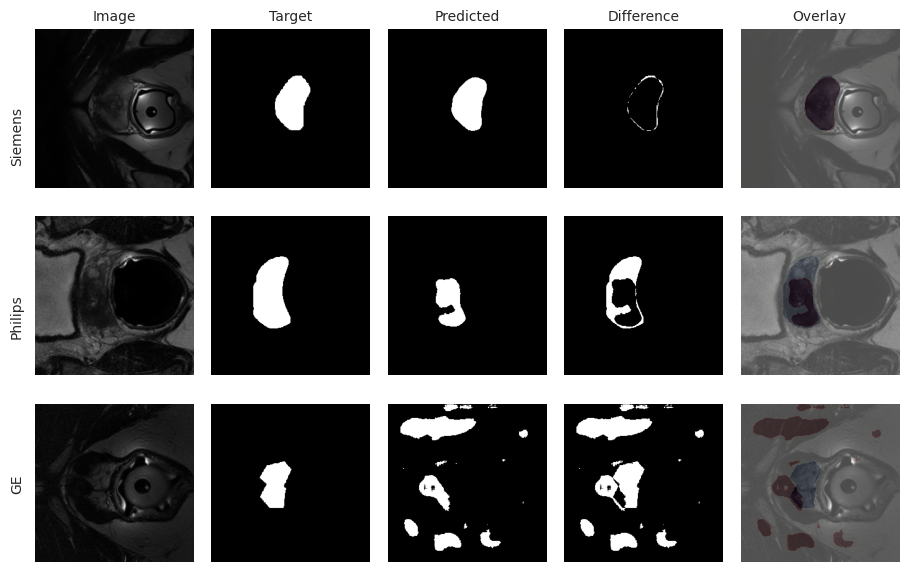

In [22]:
plot_idx(30, 25, 67)

siemens 97
siemens 0.94952613
philips 122
philips 0.66680074
ge 116
ge 0.54538655


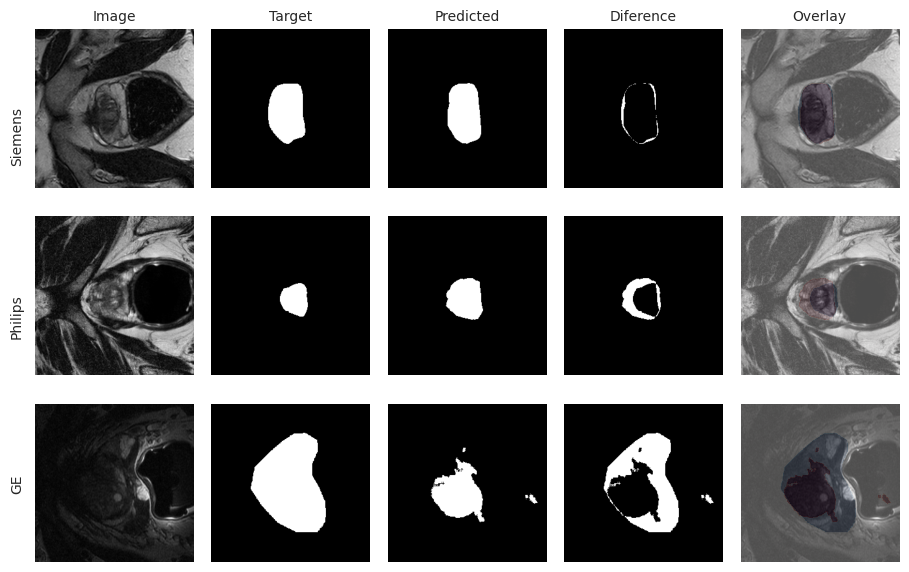

In [16]:
plot_idx(97, 122, 116)

siemens 30
siemens 0.9628461
ge 67
ge 0.077892326


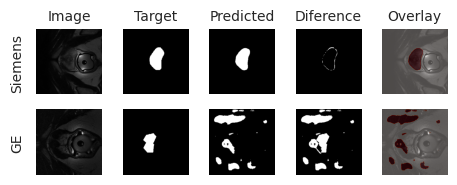

In [12]:
plot_idx_2(30, 67)

/tmp/ipykernel_3971189/3525942386.py:17: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(x='Model', y='Dice', hue='Vendor', data=df, palette=palette)


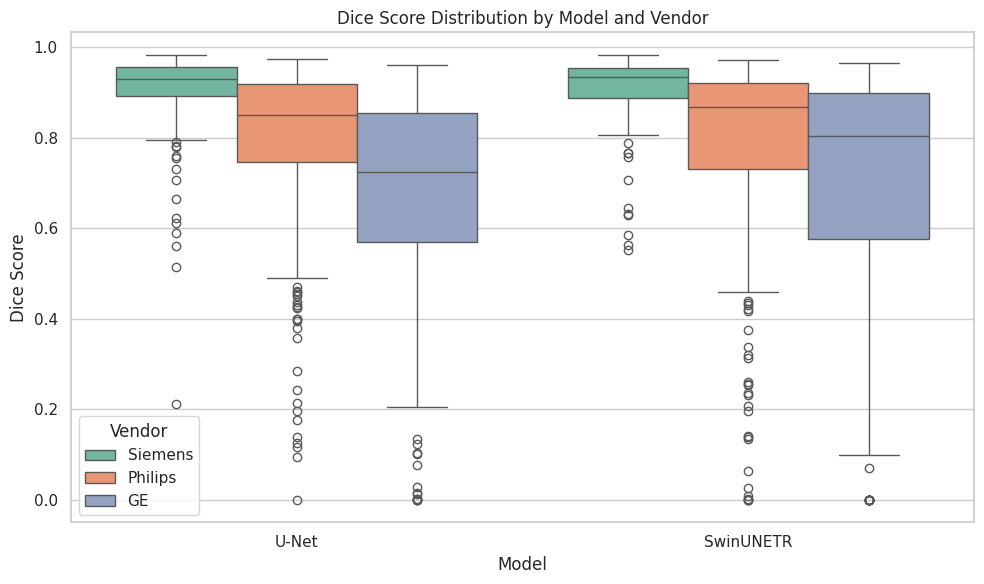

In [5]:
boxplotdata = []
for ven in test_vendors:
    for model in models:
        for d in dices_vendor[ven][model]['DS']:
            boxplotdata.append(
                {
                    "Vendor": ven.capitalize() if ven != "ge" else "GE",
                    "Model": "U-Net" if "monai" in model else "SwinUNETR",
                    "Dice": d
                }
            )

df = pd.DataFrame(boxplotdata)
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Dice', hue='Vendor', data=df, palette=palette)

# Customize the plot
plt.title('Dice Score Distribution by Model and Vendor')
plt.xlabel('Model')
plt.ylabel('Dice Score')
plt.legend(title='Vendor')

# Show the plot
plt.tight_layout()
plt.show()
        

In [2]:
pcas_path = "/workspace/out/dms"
stats_path = "/workspace/out/eval_data"
pmri_df_mahal = pd.read_csv(f"{stats_path}/mahal_dist_stats.csv")
pmri_df_metr = pd.read_csv(f"{stats_path}/dim_ent_stats.csv")
with open(f"{stats_path}/model_stats.json", "r") as f:
    pmri_model_stats = json.load(f)

In [ ]:
with open(f"{pcas_path}/pca.pkl", "rb") as f:
    pca_swin = pickle.load(f)

In [3]:
to_df = [{'model': k[:-2], 'iteration': int(k[-1]), 'vendor':k.split('_')[1], **pmri_model_stats[k]} for k in pmri_model_stats]
df = pd.DataFrame(to_df)
df

,model,iteration,vendor,mean_dice,std_dice,mean_entropy,std_entropy,ood_dice_th_5,ood_dice_th_10
0,monai-64-4-4_siemens_test,0,siemens,0.904830,0.087554,0.009205,0.004572,0.739210,0.817839
1,swinunetr_siemens_test,0,siemens,0.910375,0.069747,0.009237,0.004696,0.810015,0.842036
2,monai-64-4-4_siemens_test,1,siemens,0.906451,0.086426,0.007333,0.003647,0.780264,0.820752
3,swinunetr_siemens_test,1,siemens,0.895564,0.110797,0.009424,0.005033,0.740863,0.794136
4,monai-64-4-4_siemens_test,2,siemens,0.899074,0.101624,0.009204,0.005299,0.719009,0.785203
5,swinunetr_siemens_test,2,siemens,0.904244,0.082077,0.011702,0.005906,0.752449,0.823781
6,monai-64-4-4_philips_test,0,philips,0.774960,0.183689,0.020364,0.013507,NaN,NaN
7,swinunetr_philips_test,0,philips,0.791205,0.199829,0.014119,0.009789,NaN,NaN
8,monai-64-4-4_philips_test,1,philips,0.797278,0.170188,0.017506,0.012990,NaN,NaN
9,swinunetr_philips_test,1,philips,0.755147,0.246615,0.016261,0.011192,NaN,NaN


In [4]:
def agg_mean_std(group):
    means_dice = group['mean_dice'].values
    stds_dice = group['std_dice'].values
    means_entropy = group['mean_entropy'].values
    stds_entropy = group['std_entropy'].values
    sizes = np.ones(len(means_dice))
    agg_mean_dice = np.mean(means_dice)
    agg_mean_entropy = np.mean(means_entropy)
    agg_variance_dice = np.mean(stds_dice**2 + means_dice**2) - agg_mean_dice**2
    agg_variance_entropy = np.mean(stds_entropy**2 + means_entropy**2) - agg_mean_entropy**2
    agg_std_dice = np.sqrt(agg_variance_dice)
    agg_std_entropy = np.sqrt(agg_variance_entropy)
    return pd.Series({'mean_dice': agg_mean_dice, 'std_dice': agg_std_dice, 'mean_entropy': agg_mean_entropy, 'std_entropy': agg_std_entropy})


In [6]:
df.sort_values(by=['model','mean_dice'], inplace=False)

,model,iteration,vendor,mean_dice,std_dice,mean_entropy,std_entropy,ood_dice_th_5,ood_dice_th_10
16,monai-64-4-4_ge_test,2,ge,0.599532,0.241398,0.030390,0.014607,NaN,NaN
12,monai-64-4-4_ge_test,0,ge,0.606356,0.244916,0.029219,0.013390,NaN,NaN
14,monai-64-4-4_ge_test,1,ge,0.675699,0.226987,0.027112,0.017064,NaN,NaN
6,monai-64-4-4_philips_test,0,philips,0.774960,0.183689,0.020364,0.013507,NaN,NaN
10,monai-64-4-4_philips_test,2,philips,0.786308,0.185042,0.021641,0.014557,NaN,NaN
8,monai-64-4-4_philips_test,1,philips,0.797278,0.170188,0.017506,0.012990,NaN,NaN
4,monai-64-4-4_siemens_test,2,siemens,0.899074,0.101624,0.009204,0.005299,0.719009,0.785203
0,monai-64-4-4_siemens_test,0,siemens,0.904830,0.087554,0.009205,0.004572,0.739210,0.817839
2,monai-64-4-4_siemens_test,1,siemens,0.906451,0.086426,0.007333,0.003647,0.780264,0.820752
17,swinunetr_ge_test,2,ge,0.657314,0.259138,0.059353,0.048375,NaN,NaN


In [37]:
df.groupby(['model', 'vendor']).apply(agg_mean_std).reset_index().sort_values(by='model', ascending=False)

,model,vendor,mean_dice,std_dice,mean_entropy,std_entropy
5,swinunetr_siemens_test,siemens,0.903395,0.089420,0.010121,0.005355
4,swinunetr_philips_test,philips,0.789564,0.207720,0.017098,0.011922
3,swinunetr_ge_test,ge,0.687138,0.260802,0.036220,0.034616
2,monai-64-4-4_siemens_test,siemens,0.903452,0.092182,0.008581,0.004641
1,monai-64-4-4_philips_test,philips,0.786182,0.179996,0.019837,0.013809
0,monai-64-4-4_ge_test,ge,0.627195,0.240369,0.028907,0.015159


In [26]:
def compute_mean_std_per_vendor(df):
    vendors = list(df['vendor'].unique())
    df[]

,model,iteration,vendor,mean_dice,std_dice,mean_entropy,std_entropy,ood_dice_th_5,ood_dice_th_10
1,swinunetr_siemens_test,0,siemens,0.910375,0.069747,0.009237,0.004696,0.810015,0.842036
2,monai-64-4-4_siemens_test,1,siemens,0.906451,0.086426,0.007333,0.003647,0.780264,0.820752
0,monai-64-4-4_siemens_test,0,siemens,0.904830,0.087554,0.009205,0.004572,0.739210,0.817839
5,swinunetr_siemens_test,2,siemens,0.904244,0.082077,0.011702,0.005906,0.752449,0.823781
4,monai-64-4-4_siemens_test,2,siemens,0.899074,0.101624,0.009204,0.005299,0.719009,0.785203
3,swinunetr_siemens_test,1,siemens,0.895564,0.110797,0.009424,0.005033,0.740863,0.794136
11,swinunetr_philips_test,2,philips,0.822339,0.162574,0.020914,0.013461,NaN,NaN
8,monai-64-4-4_philips_test,1,philips,0.797278,0.170188,0.017506,0.012990,NaN,NaN
7,swinunetr_philips_test,0,philips,0.791205,0.199829,0.014119,0.009789,NaN,NaN
10,monai-64-4-4_philips_test,2,philips,0.786308,0.185042,0.021641,0.014557,NaN,NaN


In [4]:
pmri_df_metr.columns

Index(['model', 'dim_red_mode', 'n_dims', 'vendor', 'iteration', 'layer',
       'entropy_mean', 'entropy_std', 'entropy_ood_5_mean',
       'entropy_ood_5_std', 'entropy_id_5_mean', 'entropy_id_5_std',
       'entropy_ood_10_mean', 'entropy_ood_10_std', 'entropy_id_10_mean',
       'entropy_id_10_std', 'entropy_ood_95_mean', 'entropy_ood_95_std',
       'aurc_5_ent', 'auroc_5_ent', 'auprc_5_ent', 'aurc_10_ent',
       'auroc_10_ent', 'auprc_10_ent', 'aurc_95_ent', 'auroc_95_ent',
       'auprc_95_ent', 'anomaly_diff_mean', 'anomaly_diff_std',
       'anomaly_diff_ood_5_mean', 'anomaly_diff_ood_5_std',
       'anomaly_diff_id_5_mean', 'anomaly_diff_id_5_std',
       'anomaly_diff_ood_10_mean', 'anomaly_diff_ood_10_std',
       'anomaly_diff_id_10_mean', 'anomaly_diff_id_10_std',
       'anomaly_diff_ood_95_mean', 'anomaly_diff_ood_95_std', 'aurc_5_diff',
       'auroc_5_diff', 'auprc_5_diff', 'aurc_10', 'auroc_10_diff',
       'auprc_10_diff', 'aurc_95_diff', 'auroc_95_diff', 'auprc_95

In [12]:
pmri_df_metr.groupby(["layer"])['entropy_mean'].mean().reset_index().sort_values(by="entropy_mean", ascending=True)

,layer,entropy_mean
4,model.0.conv,0.021319
1,encoder2,0.023996
5,model.1.submodule.0.conv,0.027171
6,model.1.submodule.1.submodule.0.conv,0.027355
2,encoder3,0.027546
7,model.1.submodule.1.submodule.1.submodule.0.conv,0.027995
0,encoder10,0.029453
8,model.1.submodule.1.submodule.2.0.conv,0.029571
3,encoder4,0.032456


In [ ]:
pmri_df_metr.groupby(["model", "vendor"])[''].mean().reset_index().sort_values(by="entropy_mean", ascending=True)

In [3]:
def print_stats(df):
    print("\nAuroc mean per layer & model\n")
    print(df.groupby(['model', 'layer'])['auroc'].mean().reset_index())
    print("\nAuroc mean per num_dims & model\n")
    print(df.groupby(['model', 'n_dims'])['auroc'].mean().reset_index())
    print("\nAuroc mean per dim reduction method\n")
    print(df[df.n_dims > 4].groupby('dim_red_mode')['auroc'].mean().reset_index())
    print("\nAuroc mean IPCA vs PCA comparison\n")
    print(df[df.n_dims <= 4].groupby(['dim_red_mode', 'n_dims'])['auroc'].mean().reset_index().sort_values(by="n_dims"))
    print("\nAuroc mean per dim reduction method and n_dims\n")
    print(df.groupby(['dim_red_mode', 'n_dims'])['auroc'].mean().reset_index().sort_values(by="auroc", ascending=False))
    print("\nAuroc mean by vendor\n")
    print(df.groupby(['vendor', 'model'])['auroc'].mean().reset_index().sort_values(by="auroc", ascending=False))
    print("\nAuroc mean by vendor and method\n")
    print(df.groupby(['vendor', 'dim_red_mode'])['auroc'].mean().reset_index().sort_values(by="auroc", ascending=False))

In [10]:
def print_stats_anomaly(df, word):
    print(df.groupby(['model', 'dim_red_mode', 'n_dims', 'vendor'])[f'auroc_5_{word}', f'auroc_10_{word}', f'auroc_95_{word}'].mean().reset_index().sort_values(by=f"auroc_5_{word}", ascending=False))

In [12]:
print_stats_anomaly(anomaly_df_pmri, "diff")

           model dim_red_mode  n_dims   vendor  auroc_5_diff  auroc_10_diff  \
13  monai-64-4-4         IPCA      32  philips      0.683321       0.673726   
3   monai-64-4-4         IPCA       4       ge      0.664299       0.669559   
18  monai-64-4-4          PCA       4       ge      0.658283       0.654806   
12  monai-64-4-4         IPCA      32       ge      0.656174       0.651602   
10  monai-64-4-4         IPCA      16  philips      0.654138       0.642950   
6   monai-64-4-4         IPCA       8       ge      0.650595       0.649175   
7   monai-64-4-4         IPCA       8  philips      0.641826       0.628176   
9   monai-64-4-4         IPCA      16       ge      0.640111       0.643913   
15  monai-64-4-4          PCA       2       ge      0.627203       0.618620   
4   monai-64-4-4         IPCA       4  philips      0.621778       0.605896   
0   monai-64-4-4         IPCA       2       ge      0.618014       0.615181   
19  monai-64-4-4          PCA       4  philips      

/tmp/ipykernel_1118878/3177591555.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['model', 'dim_red_mode', 'n_dims', 'vendor'])[f'auroc_5_{word}', f'auroc_10_{word}', f'auroc_95_{word}'].mean().reset_index().sort_values(by=f"auroc_5_{word}", ascending=False))


In [4]:
print_stats(pmri_scaled_df)


Auroc mean per layer & model

          model                                             layer     auroc
0  monai-64-4-4                                      model.0.conv  0.604050
1  monai-64-4-4                          model.1.submodule.0.conv  0.607379
2  monai-64-4-4              model.1.submodule.1.submodule.0.conv  0.603967
3  monai-64-4-4  model.1.submodule.1.submodule.1.submodule.0.conv  0.596988
4     swinunetr                                          decoder5  0.574948
5     swinunetr                                         encoder10  0.569535
6     swinunetr                        swinViT.layers4.0.blocks.1  0.567638
7     swinunetr                      swinViT.layers4.0.downsample  0.568069

Auroc mean per num_dims & model

           model   n_dims     auroc
0   monai-64-4-4      2.0  0.615101
1   monai-64-4-4      4.0  0.611372
2   monai-64-4-4      8.0  0.601523
3   monai-64-4-4     16.0  0.599779
4   monai-64-4-4     32.0  0.592016
5   monai-64-4-4  10000.0  0.578507

In [39]:
print_stats(pmri_scaled_df)


Auroc mean per layer & model

          model                                             layer     auroc
0  monai-64-4-4                                      model.0.conv  0.611745
1  monai-64-4-4                          model.1.submodule.0.conv  0.631908
2  monai-64-4-4              model.1.submodule.1.submodule.0.conv  0.620327
3  monai-64-4-4  model.1.submodule.1.submodule.1.submodule.0.conv  0.606473
4     swinunetr                                          decoder5  0.533242
5     swinunetr                                         encoder10  0.523172
6     swinunetr                        swinViT.layers4.0.blocks.1  0.511589
7     swinunetr                      swinViT.layers4.0.downsample  0.514239

Auroc mean per num_dims & model

           model   n_dims     auroc
0   monai-64-4-4      2.0  0.635118
1   monai-64-4-4      4.0  0.633386
2   monai-64-4-4      8.0  0.624001
3   monai-64-4-4     16.0  0.617784
4   monai-64-4-4     32.0  0.602852
5   monai-64-4-4  10000.0  0.559259

In [33]:
print_stats(heart_df)


Auroc mean per layer & model

          model                                             layer     auroc
0  monai-64-4-4                                      model.0.conv  0.576003
1  monai-64-4-4                          model.1.submodule.0.conv  0.549900
2  monai-64-4-4              model.1.submodule.1.submodule.0.conv  0.555850
3  monai-64-4-4  model.1.submodule.1.submodule.1.submodule.0.conv  0.554327
4     swinunetr                                          decoder5  0.548417
5     swinunetr                                         encoder10  0.539232
6     swinunetr                        swinViT.layers4.0.blocks.1  0.542977
7     swinunetr                      swinViT.layers4.0.downsample  0.542428

Auroc mean per num_dims & model

           model   n_dims     auroc
0   monai-64-4-4      2.0  0.566709
1   monai-64-4-4      4.0  0.558643
2   monai-64-4-4      8.0  0.553478
3   monai-64-4-4     16.0  0.551095
4   monai-64-4-4     32.0  0.548153
5   monai-64-4-4  10000.0  0.568730

In [ ]:
model_path 